<h1 align="center">Scientific Programming in Python</h1>
<h2 align="center">Topic 8: Basics of Data Parallelism  </h2> 


_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - June 2017._

In [4]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import threading
import multiprocessing
from ipyparallel import Client

def image_plot(img):
    """
    img is an (nx,ny,3) numpy.array
    """
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

En esta actividad realizaremos convolución de imágenes (tarea altamente paralelizable), sobre imágenes de gran tamaño y de forma paralela, utilizando bibliotecas de paralelización en Python.

En primer lugar cargamos y visualizamos la imágen a trabajar:

In [54]:
img = plt.imread('heic1608b.jpg', format='jpeg')[0:8660,:,:]
print(img.shape)

(8660, 10260, 3)


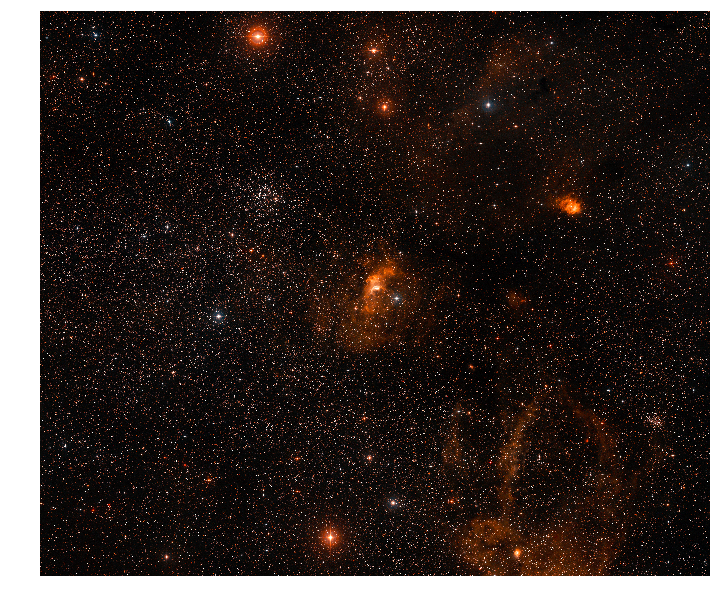

In [5]:
image_plot(img)

Lo que se desea es aplicar un filtro de _blurring_ (Gaussiano) sobre tal imágen. En este caso ocuparemos en filtro/kernel Gaussiano de `5x5` generado por la siguiente función:

In [6]:
def gaussian_kernel(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [52]:
K = gaussian_kernel((5,5))
print(K[0])

[  6.96247819e-08   2.80886418e-05   2.07548550e-04   2.80886418e-05
   6.96247819e-08]


Para ello se le solicita lo siguiente:

1. Usando `IPython.Parallel` desarrolle una solución para aplicar el filtro de convolución `K` sobre la imágen dada. Usted es libre de elegir el modo (_synchronous_ o _asynchronous_) y el modo de despacho de tareas. __Notar:__ Que la imágen tiene 3 canales (RGB) y debe aplicar el filtro independientemente en cada uno.
2. Ejecute su solución sobre la imágen y muestre el resultado.
3. Ejecute su solución anterior sobre un _pool_ de `1`, `2`, `4` y `8` _engines_ realizando un análisis de tiempo con `%timeit`. Extraiga conclusiones de los resultados obtenidos (considere las características del CPU de su computador). 

### Pregunta 1

In [55]:
def aplicar_kernel(row):
    
    result = np.zeros((1,img.shape[1],3), int)
    #result = np.zeros((1,10,3), "uint8")
    K = gaussian_kernel((5,5))
    for col in range(2,img.shape[1]-2):
    #for col in range(2,10):
        result[0,col,0] = round(np.sum(K*img[row-2:row+3,col-2:col+3,0]))
        result[0,col,1] = round(np.sum(K*img[row-2:row+3,col-2:col+3,1]))
        result[0,col,2] = round(np.sum(K*img[row-2:row+3,col-2:col+3,2]))
    return result

#rows = list(range(2,50-2))
rows = list(range(2,img.shape[0]-2))

### Pregunta 2

In [ ]:
rc = Client()
v = rc.load_balanced_view()
ar = v.map(aplicar_kernel, rows)

In [ ]:
if ar.ready():
    imgk= np.vstack(ar.result())
    image_plot(imgk)

### Pregunta 3
